# Deep learning for timeseries

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array

In [10]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [31]:
temperature = df["T (degC)"].values

In [34]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Plotting the temperature timeseries**

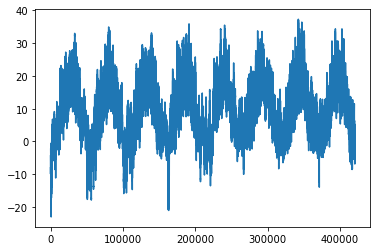

In [37]:
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

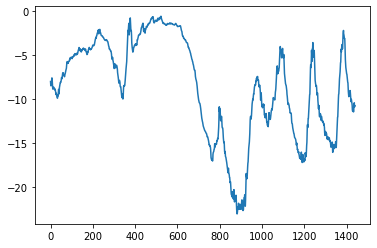

In [38]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [40]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("Train samples:", num_train_samples)
print("Validation samples:", num_val_samples)
print("Testing samples:", num_test_samples)

Train samples: 210225
Validation samples: 105112
Testing samples: 105114


### Preparing the data

**Normalizing the data**

In [41]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [42]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [44]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [47]:
print("samples shape:", samples[0].shape)
print("targets shape:", targets.shape)

samples shape: (120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

In [70]:
def evaluate_naive_method(dataset):
    
    total_abs_err = 0.
    samples_seen = 0
    
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
        
    return total_abs_err / samples_seen

In [71]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62
